<img src="logoucm.png" style="height: 100px">
<center style="color:#888">Big Data<br/></center>


<h1><center>Calidad del aire en la Comunidad de Madrid</center></h1>

# Introducción

Los datos empleados en este trabajo son datos recogidos de forma diaria desde 2010 hasta 2023 por la Comunidad de Madrid sobre la concentración de diferentes contaminantes en 24 estaciones repartidas por todo su territorio. Estos datos son publicado diariamente en su página web <a href="https://airedemadrid.madrid.es/portal/site/calidadaire">Portal de Calidad del aire</a>, así como un **Índice de Calidad del Aire** que tiene como objetivo dar una valoración de los efectos de la contaminación atmosférica sobre la salud.

Se puede obtener más información de las variables recogidas en el <a href="http://localhost:8888/tree/OneDrive/Escritorio/CALIDAD%20AIRE%20MADRID">Interprete fichero</a>.
Se presenta una breve descripción de los datos recogidos.


| Atributo | Descripción |
| :- |:- |
|**PROVINCIA**| Identificador de la provincia (en este caso siempre '28'-Madrid)|
|**MUNICIPIO**| Identificador del municipio (en este caso siempre '79'-Mardrid|
|**ESTACION**| Identificador de la estación de recogida de los contaminantes|
|**MAGNITUD**| Identificador del contaminante|
|**PUNTO MUESTREO**| Identificador del punto de muestro|
|**ANO**| Año de recogida del dato|
|**MES**| Mes de recogida el dato|
|**D01**| D0_X_ indica el día del mes|
|**V01**| V0_X_ indica si el dato está verificado o no (Sí: "V", NO: "N")|

# Librerías

In [ ]:
#pip install geopandas

In [1]:
# Librerias 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt  

import geopandas as gpd

from sklearn.impute import KNNImputer
from shapely.geometry import Point, Polygon

%matplotlib inline

# 1. Análisis Exploratorio de los Datos

## 1.1 Limpieza de la base de datos

En primer lugar, abrimos el fichero con los datos y estudiamos la dimensión y estructura de los mismos. 

In [2]:
# Cargamos los datos
df = pd.read_csv("datos_total.csv", delimiter = ",")
df.head(5)

,Unnamed: 0,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,0,28,79,4,1,28079004_1_38,2010,1,12.0,V,...,16.0,V,21.0,V,22.0,V,17.0,V,15.0,V
1,1,28,79,4,1,28079004_1_38,2010,2,18.0,V,...,15.0,V,13.0,V,0.0,N,0.0,N,0.0,N
2,2,28,79,4,1,28079004_1_38,2010,3,13.0,V,...,14.0,V,16.0,V,15.0,V,13.0,V,14.0,V
3,3,28,79,4,1,28079004_1_38,2010,4,14.0,V,...,9.0,V,9.0,V,9.0,V,9.0,V,0.0,N
4,4,28,79,4,1,28079004_1_38,2010,5,8.0,V,...,9.0,V,9.0,V,9.0,V,9.0,V,9.0,V


In [3]:
# Numero de obeservaciones y de variables
df.shape

(21633, 70)

Tenemos 21633 registros de 70 variables, aunque eliminamos las variables ***provoncia*** y ***municipio*** por ser redundantes. 

In [4]:
# Variables
df = df.drop(columns=['Unnamed: 0', 'PROVINCIA', 'MUNICIPIO'], axis = 1)

En primer lugar, vamos a tratar con el problema de los datos no verificados. Sólo son validos aquellos datos acompañados de un código de verificación *V*.

El estudio que vamos a realizar crea un índice a partir de ciertos compuestos (<a href="https://airedemadrid.madrid.es/portales/calidadaire/es/Bases-de-datos-y-publicaciones/Bases-de-datos-de-calidad-del-aire/Indices-y-zonas/Indice-de-calidad-del-aire/?vgnextfmt=default&vgnextoid=303d635a41187710VgnVCM1000001d4a900aRCRD&vgnextchannel=480285a1259d7710VgnVCM2000001f4a900aRCRD">Índice de Calidad del Aire</a>). Por ello, vamos a seleccionar las magnitudes que nos interesan reduciendo así la dimensionalidad del problema.

*Los compuestos que se emplean para calcular el índice de calidad son las partículas en suspensión (PM10 y PM2,5), dióxido de azufre, dióxido de nitrógeno y ozono. Para cada uno de estos contaminantes se establece un índice parcial, de forma que el peor valor de los cinco definirá el índice global y, por lo tanto, la calidad del aire en el municipio de Madrid.*

| Contaminantes | id| Muy bueno | Bueno | Regular | Malo | Muy malo |
| :- |:- |:-|:-|:-|:-| :-|
|Partículas PM2,5| 9| 0-15|16-30|31-55|56-110|>110|
|Partículas PM10| 10| 0-25|26-50|51-90|91-180|>180|
|NO2| 8| 0-50|51-100|101-200|201-400|>400|
|O3| 14|0-60|61-120|121-180|181-240|>240|
|SO2| 1|0-50|51-100|101-350|351-500|>500|

Por tanto, nos quedamos con los registros de los contaminantes que conforman el índice previamente definido.

In [5]:
# DataFrame con los contaminantes de interes
df_contaminantes = df[(df['MAGNITUD'] == 9) | (df['MAGNITUD'] == 10) | 
                      (df['MAGNITUD'] == 8) | (df['MAGNITUD'] == 14) |
                      (df['MAGNITUD'] == 1)]
df_contaminantes.head(5)

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,D02,V02,D03,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,4,1,28079004_1_38,2010,1,12.0,V,15.0,V,17.0,...,16.0,V,21.0,V,22.0,V,17.0,V,15.0,V
1,4,1,28079004_1_38,2010,2,18.0,V,20.0,V,24.0,...,15.0,V,13.0,V,0.0,N,0.0,N,0.0,N
2,4,1,28079004_1_38,2010,3,13.0,V,15.0,V,13.0,...,14.0,V,16.0,V,15.0,V,13.0,V,14.0,V
3,4,1,28079004_1_38,2010,4,14.0,V,14.0,V,13.0,...,9.0,V,9.0,V,9.0,V,9.0,V,0.0,N
4,4,1,28079004_1_38,2010,5,8.0,V,8.0,V,8.0,...,9.0,V,9.0,V,9.0,V,9.0,V,9.0,V


In [8]:
dias = ['D01','D02','D03','D04','D05','D06','D07','D08','D09','D10',
       'D11','D12','D13','D14','D15','D16','D17','D18','D19','D20',
       'D21','D22','D23','D24','D25','D26','D27','D28','D29','D30','D31']

verf = ['V01','V02','V03','V04','V05','V06','V07','V08','V09','V10',
       'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
       'V21','V22','V23','V24','V25','V26','V27','V28','V29','V30','V31']

In [9]:
# Dias 
df_dias = df_contaminantes.melt(id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES'],
                                value_vars = dias,
                                var_name = 'DIA',
                                value_name = 'VALOR')
# Verificaciones
df_verf= df_contaminantes.melt(id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES'],
                               value_vars = verf,
                               var_name = 'VER',
                               value_name = 'VV')

df_dias['VV'] = df_verf['VV']
df1 = df_dias

Con este dataframe, vamos a diferencias entre los valores no verificados (aquellos que van seguidos de un 'N') y los valores no medidos por no existir el día en concreto (p.e, 30-02).

En primer lugar, eliminamos del dataframe aquellos días que no existen. 

In [10]:
date_str = df1['ANO'].astype(str) + '-' + df1['MES'].astype(str) + '-' + df1['DIA'].str.replace('D', '').astype(str)
df1['date'] = pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce')
df1 = df1.dropna(subset=['date'])
df1 = df1.sort_values(['ESTACION','MAGNITUD','date'])

In [11]:
df1

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,VALOR,VV,date
0,4,1,28079004_1_38,2010,1,D01,12.0,V,2010-01-01
9486,4,1,28079004_1_38,2010,1,D02,15.0,V,2010-01-02
18972,4,1,28079004_1_38,2010,1,D03,17.0,V,2010-01-03
28458,4,1,28079004_1_38,2010,1,D04,16.0,V,2010-01-04
37944,4,1,28079004_1_38,2010,1,D05,16.0,V,2010-01-05
...,...,...,...,...,...,...,...,...,...
256121,60,14,28079060_14_6,2021,12,D27,52.0,V,2021-12-27
265607,60,14,28079060_14_6,2021,12,D28,42.0,V,2021-12-28
275093,60,14,28079060_14_6,2021,12,D29,19.0,V,2021-12-29
284579,60,14,28079060_14_6,2021,12,D30,9.0,V,2021-12-30


En segundo lugar, vamos a poner a valor NaN los datos no verificados para posteriormente realizar una imputación de esos valores.

In [12]:
df1.loc[df1['VV'] != 'V', 'VALOR'] = np.nan

In [13]:
# Comprobamos los valores nulos
df1.isnull().sum()

ESTACION             0
MAGNITUD             0
PUNTO_MUESTREO       0
ANO                  0
MES                  0
DIA                  0
VALOR             3920
VV                   0
date                 0
dtype: int64

In [14]:
# Comprobamos filas duplicadas
df1.duplicated().sum()

0

## 1.2 Imputación de missing

Podemos imputar missing de dos formas diferentes:

1. Interpolación 
2. KNN

**Interpolación**

In [15]:
df1['VALOR'].interpolate(method='linear', inplace=True)
df1 = df1.drop(['VV'],axis=1)

## 1.3 Estadísticos descriptivos

Creamos 2 dataframes: Uno referente a las magnitudes y otro agrupado por zonas.

**Por magnitudes**

In [21]:
# Creamos el DataFrame con el que haremos las series temporales de los contaminantes
df_magnitudes = df1.pivot_table(index=['ESTACION', 'ANO', 'MES', 'DIA', 'date'], columns='MAGNITUD', values='VALOR')
df_magnitudes = df_magnitudes.reset_index()
df_magnitudes.columns = ['ESTACION','ANO','MES','DIA','date','SO2', 'NO2', 'PM2.5', 'PM10','O3']
df_magnitudes

,ESTACION,ANO,MES,DIA,date,SO2,NO2,PM2.5,PM10,O3
0,4,2010,1,D01,2010-01-01,12.0,12.0,NaN,NaN,NaN
1,4,2010,1,D02,2010-01-02,15.0,40.0,NaN,NaN,NaN
2,4,2010,1,D03,2010-01-03,17.0,51.0,NaN,NaN,NaN
3,4,2010,1,D04,2010-01-04,16.0,53.0,NaN,NaN,NaN
4,4,2010,1,D05,2010-01-05,16.0,46.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
104883,60,2021,12,D27,2021-12-27,NaN,13.0,NaN,6.0,52.0
104884,60,2021,12,D28,2021-12-28,NaN,19.0,NaN,5.0,42.0
104885,60,2021,12,D29,2021-12-29,NaN,36.0,NaN,9.0,19.0
104886,60,2021,12,D30,2021-12-30,NaN,44.0,NaN,8.0,9.0


**Nota:** Para continuar, en principio nos quedamos con aquellas entradas que no tienen valores nulos, e.d, las estaciones que recogen todos los contamintantes. Así, realizamos un análisis descriptivo de los diferentes contaminantes.

In [60]:
df_comp_mag = df_magnitudes.dropna()

In [61]:
df_comp_mag

,ESTACION,ANO,MES,DIA,date,SO2,NO2,PM2.5,PM10,O3
4322,8,2010,1,D01,2010-01-01,9.00000,29.0,7.0,12.0,50.0
4323,8,2010,1,D02,2010-01-02,10.00000,42.0,9.0,16.0,24.0
4324,8,2010,1,D03,2010-01-03,11.00000,51.0,10.0,13.0,13.0
4325,8,2010,1,D04,2010-01-04,12.00000,52.0,6.0,8.0,12.0
4326,8,2010,1,D05,2010-01-05,12.00000,46.0,7.0,12.0,21.0
...,...,...,...,...,...,...,...,...,...,...
30220,24,2021,1,D27,2021-01-27,3.53125,13.0,5.0,7.0,27.0
30221,24,2021,1,D28,2021-01-28,3.62500,13.0,6.0,8.0,20.0
30222,24,2021,1,D29,2021-01-29,3.71875,11.0,7.0,9.0,25.0
30223,24,2021,1,D30,2021-01-30,3.81250,2.0,4.0,6.0,57.0


**Por zonas**

In [ ]:
# Creamos el DataFrame con el que haremos las series temporales por zonas
df_zonas = df1.pivot_table(index=['MAGNITUD', 'ANO', 'MES', 'DIA'], columns='ESTACION', values='VALOR')
df_zonas = df_zonas.reset_index()
df_zonas

**Nota:** Para continuar, en principio nos quedamos con aquellas entradas que no tienen valores nulos, e.d, las estaciones que recogen todos los contamintantes. Así, realizamos un análisis descriptivo de los diferentes contaminantes.

In [ ]:
df_comp_zonas = df_zonas.dropna()
df_comp_zonas

## 1.4 Outliers

# 2. Índice de Calidad del Aire

En primer lugar, vamos a crear un indice de calidad del aire. Así, para cada magnitud determinamos el indice de la forma descrita al principio.

## 2.1 Por magnitudes

| Contaminantes | id| Muy bueno | Bueno | Regular | Malo | Muy malo |
| :- |:- |:-|:-|:-|:-| :-|
|Partículas PM2,5| 9| 0-15|16-30|31-55|56-110|>110|
|Partículas PM10| 10| 0-25|26-50|51-90|91-180|>180|
|NO2| 8| 0-50|51-100|101-200|201-400|>400|
|O3| 14|0-60|61-120|121-180|181-240|>240|
|SO2| 1|0-50|51-100|101-350|351-500|>500|

In [62]:
df_comp_mag

,ESTACION,ANO,MES,DIA,date,SO2,NO2,PM2.5,PM10,O3
4322,8,2010,1,D01,2010-01-01,9.00000,29.0,7.0,12.0,50.0
4323,8,2010,1,D02,2010-01-02,10.00000,42.0,9.0,16.0,24.0
4324,8,2010,1,D03,2010-01-03,11.00000,51.0,10.0,13.0,13.0
4325,8,2010,1,D04,2010-01-04,12.00000,52.0,6.0,8.0,12.0
4326,8,2010,1,D05,2010-01-05,12.00000,46.0,7.0,12.0,21.0
...,...,...,...,...,...,...,...,...,...,...
30220,24,2021,1,D27,2021-01-27,3.53125,13.0,5.0,7.0,27.0
30221,24,2021,1,D28,2021-01-28,3.62500,13.0,6.0,8.0,20.0
30222,24,2021,1,D29,2021-01-29,3.71875,11.0,7.0,9.0,25.0
30223,24,2021,1,D30,2021-01-30,3.81250,2.0,4.0,6.0,57.0


In [63]:
# Indice para S02
# Definimos los rangos
bins = [0,50,100,350,500,float("inf")]
labels = [1,2,3,4,5]
# Creamos una columna con el indice
df_comp_mag["I1"] = pd.cut(df_comp_mag["SO2"], bins=bins, labels=labels)

# Indice para N02
bins = [0,50,100,200,400,float("inf")]
df_comp_mag["I2"] = pd.cut(df_comp_mag["NO2"], bins=bins, labels=labels)

# Indice para PM2.5
bins = [0,15,30,55,110,float("inf")]
df_comp_mag["I3"] = pd.cut(df_comp_mag["PM2.5"], bins=bins, labels=labels)

# Indice para PM10
bins = [0,25,50,90,180,float("inf")]
df_comp_mag["I4"] = pd.cut(df_comp_mag["PM10"], bins=bins, labels=labels)

# Indice para O3
bins = [0,60,120,180,240,float("inf")]
df_comp_mag["I5"] = pd.cut(df_comp_mag["O3"], bins=bins, labels=labels)

C:\Users\sofia\AppData\Local\Temp\ipykernel_7548\4211814441.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_mag["I1"] = pd.cut(df_comp_mag["SO2"], bins=bins, labels=labels)
C:\Users\sofia\AppData\Local\Temp\ipykernel_7548\4211814441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_mag["I2"] = pd.cut(df_comp_mag["NO2"], bins=bins, labels=labels)
C:\Users\sofia\AppData\Local\Temp\ipykernel_7548\4211814441.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [77]:
df_comp_mag

,ESTACION,ANO,MES,DIA,date,SO2,NO2,PM2.5,PM10,O3,I1,I2,I3,I4,I5
4322,8,2010,1,D01,2010-01-01,9.00000,29.0,7.0,12.0,50.0,1,1,1,1,1
4323,8,2010,1,D02,2010-01-02,10.00000,42.0,9.0,16.0,24.0,1,1,1,1,1
4324,8,2010,1,D03,2010-01-03,11.00000,51.0,10.0,13.0,13.0,1,2,1,1,1
4325,8,2010,1,D04,2010-01-04,12.00000,52.0,6.0,8.0,12.0,1,2,1,1,1
4326,8,2010,1,D05,2010-01-05,12.00000,46.0,7.0,12.0,21.0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30220,24,2021,1,D27,2021-01-27,3.53125,13.0,5.0,7.0,27.0,1,1,1,1,1
30221,24,2021,1,D28,2021-01-28,3.62500,13.0,6.0,8.0,20.0,1,1,1,1,1
30222,24,2021,1,D29,2021-01-29,3.71875,11.0,7.0,9.0,25.0,1,1,1,1,1
30223,24,2021,1,D30,2021-01-30,3.81250,2.0,4.0,6.0,57.0,1,1,1,1,1


Para crear un índice general, realizamos un PCA y un Kernel PCA en las variables que indican índice.

**PCA**

In [79]:
# Librerias
from sklearn.decomposition import PCA, KernelPCA

In [80]:
# PCA para las varibales que dan un indice
# Variables para realizar el PCA
indices = df_comp_mag[['I1','I1','I3','I4','I5']]

# PCA con 2 componentes
pca2 = PCA(n_components=2)
valores_pca2 = pca2.fit_transform(indices)

resultados_pca2 = pd.DataFrame({'C1': valores_pca2[:,0], 'C2': valores_pca2[:,1]})
resultados_pca2

,C1,C2
0,-0.287158,-0.362347
1,-0.287158,-0.362347
2,-0.287158,-0.362347
3,-0.287158,-0.362347
4,-0.287158,-0.362347
...,...,...
8244,-0.287158,-0.362347
8245,-0.287158,-0.362347
8246,-0.287158,-0.362347
8247,-0.287158,-0.362347


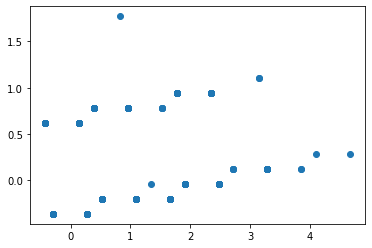

In [85]:
# Grafico para 2 componentes
plt.scatter(valores_pca2[:,0], valores_pca2[:,1])

In [92]:
# Variabilidad
fit = pca2.fit(indices)
print(fit.explained_variance_ratio_)

[0.55584943 0.33418929]


**PCA 3 COMPONENTES**

In [81]:
# PCA con 3 componentes
pca3 = PCA(n_components=3)
valores_pca3 = pca3.fit_transform(indices)

resultados_pca3 = pd.DataFrame({'C1': valores_pca3[:,0], 'C2': valores_pca3[:,1], 'C3': valores_pca3[:,2]})
resultados_pca3

,C1,C2,C3
0,-0.287158,-0.362347,-0.014332
1,-0.287158,-0.362347,-0.014332
2,-0.287158,-0.362347,-0.014332
3,-0.287158,-0.362347,-0.014332
4,-0.287158,-0.362347,-0.014332
...,...,...,...
8244,-0.287158,-0.362347,-0.014332
8245,-0.287158,-0.362347,-0.014332
8246,-0.287158,-0.362347,-0.014332
8247,-0.287158,-0.362347,-0.014332


In [93]:
fit3 = pca3.fit(indices)
print(fit3.explained_variance_ratio_)

[0.55584943 0.33418929 0.10996128]


Por tanto, llegamos a la siguiente tabla para la cual podríamos realizar predicción de la serie temporal.

In [94]:
df_comp_mag["C1"] = valores_pca2[:,0]
df_comp_mag["C2"] = valores_pca2[:,1]

C:\Users\sofia\AppData\Local\Temp\ipykernel_7548\1598084832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_mag["C1"] = valores_pca2[:,0]
C:\Users\sofia\AppData\Local\Temp\ipykernel_7548\1598084832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_mag["C2"] = valores_pca2[:,1]


In [ ]:
df_comp_mag

**Kernel PCA**

## 2.2 Por zonas

# 3. Predicción de la serie temporal

## 3.1 Series temporales univariantes por contaminante

**Nota**:Para intentar ajustar un modelo, cogemos una estacion para tener un dato por día.

In [102]:
ts = df_comp_mag[df_comp_mag['ESTACION']==8]
ts

,ESTACION,ANO,MES,DIA,date,SO2,NO2,PM2.5,PM10,O3,I1,I2,I3,I4,I5,C1,C2
4322,8,2010,1,D01,2010-01-01,9.0,29.0,7.0,12.0,50.0,1,1,1,1,1,-0.287158,-0.362347
4323,8,2010,1,D02,2010-01-02,10.0,42.0,9.0,16.0,24.0,1,1,1,1,1,-0.287158,-0.362347
4324,8,2010,1,D03,2010-01-03,11.0,51.0,10.0,13.0,13.0,1,2,1,1,1,-0.287158,-0.362347
4325,8,2010,1,D04,2010-01-04,12.0,52.0,6.0,8.0,12.0,1,2,1,1,1,-0.287158,-0.362347
4326,8,2010,1,D05,2010-01-05,12.0,46.0,7.0,12.0,21.0,1,1,1,1,1,-0.287158,-0.362347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8700,8,2021,12,D27,2021-12-27,3.0,24.0,3.0,6.0,45.0,1,1,1,1,1,-0.287158,-0.362347
8701,8,2021,12,D28,2021-12-28,3.0,31.0,3.0,7.0,40.0,1,1,1,1,1,-0.287158,-0.362347
8702,8,2021,12,D29,2021-12-29,3.0,45.0,10.0,15.0,19.0,1,1,1,1,1,-0.287158,-0.362347
8703,8,2021,12,D30,2021-12-30,4.0,58.0,10.0,14.0,10.0,1,2,1,1,1,-0.287158,-0.362347


**SO2**

Vamos a estudiar la serie temporal para el contaminante $SO_2$. 

In [109]:
# Librerias
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

Text(0, 0.5, 'ug/m^3')

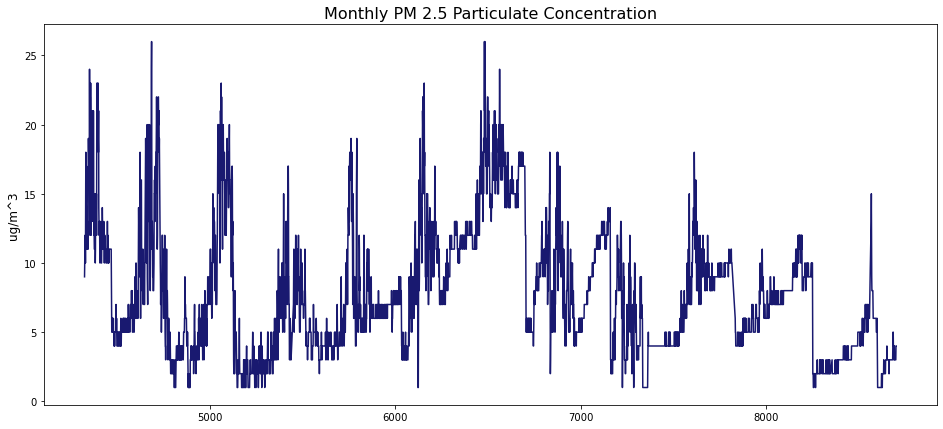

In [110]:
ts['SO2'].plot(lw=1.5, color='midnightblue', figsize=(16, 7))
plt.title('Monthly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12)

In [150]:
so2 = ts['SO2']
so2 = so2.values

In [151]:
# Descomposicion de la serie temporal
result = seasonal_decompose(so2,period=365)

# Resultados
print(result.trend)
print(result.seasonal)
print(result.resid)

[nan nan nan ... nan nan nan]
[3.18560484 2.09444668 2.82122128 ... 3.18560484 2.09444668 2.82122128]
[nan nan nan ... nan nan nan]
